In [ ]:
!pip install torchtext==0.17.0 torch==2.2.0
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 70.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 755.5/755.5 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 97.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 85.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 54.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.0/166.0 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9

In [ ]:
!python -m spacy download en_core_web_sm
!python -m spacy download de_core_news_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 103.8 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.6/14.6 MB 98.7 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('de_core_news_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [ ]:
%%writefile main.py

import torch
import torch.nn as nn
import torch.optim as optim
import random
import numpy as np
import spacy
import datasets
import torchtext
import tqdm



from tqdm.notebook import tqdm, trange
import matplotlib.pyplot as plt
import numpy as np

import copy
import random
import time
import os
import json

import torch.utils.data as data
from torch.utils.data.distributed import DistributedSampler
from torch.nn.parallel import DistributedDataParallel as DDP
import torch.distributed as dist
import torch.multiprocessing as mp

SEED = 1234
ROOT = "."
MODEL_NAME = "RNN"
SENARIO = "1GPU"
EPOCHS = 10
CLIP = 1.0
teacher_forcing_ratio = 0.5
BATCH_SIZE = 512

outdir = "./my_datasets"
os.makedirs(outdir, exist_ok=True)
os.environ['HF_DATASETS_CACHE'] = outdir


random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

"""# 2. Initialize the DDP Environment"""

def setup(rank, world_size):
    os.environ['MASTER_ADDR'] = 'localhost'  # Change this to the master node's IP address if using multiple machines
    os.environ['MASTER_PORT'] = '12345'  # Pick a free port on the master node
    dist.init_process_group("nccl", rank=rank, world_size=world_size)

def cleanup():
    dist.destroy_process_group()

"""# 3. Define a Model."""

class Encoder(nn.Module):
    def __init__(self, input_dim, embedding_dim, hidden_dim, dropout):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.embedding = nn.Embedding(input_dim, embedding_dim)
        self.rnn = nn.GRU(embedding_dim, hidden_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, src):
        # src = [src length, batch size]
        embedded = self.dropout(self.embedding(src))
        # embedded = [src length, batch size, embedding dim]
        outputs, hidden = self.rnn(embedded)  # no cell state in GRU!
        # outputs = [src length, batch size, hidden dim * n directions]
        # hidden = [n layers * n directions, batch size, hidden dim]
        # outputs are always from the top hidden layer
        return hidden


class Decoder(nn.Module):
    def __init__(self, output_dim, embedding_dim, hidden_dim, dropout):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        self.embedding = nn.Embedding(output_dim, embedding_dim)
        self.rnn = nn.GRU(embedding_dim + hidden_dim, hidden_dim)
        self.fc_out = nn.Linear(embedding_dim + hidden_dim * 2, output_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, input, hidden, context):
        # input = [batch size]
        # hidden = [n layers * n directions, batch size, hidden dim]
        # context = [n layers * n directions, batch size, hidden dim]
        # n layers and n directions in the decoder will both always be 1, therefore:
        # hidden = [1, batch size, hidden dim]
        # context = [1, batch size, hidden dim]
        input = input.unsqueeze(0)
        # input = [1, batch size]
        embedded = self.dropout(self.embedding(input))
        # embedded = [1, batch size, embedding dim]
        emb_con = torch.cat((embedded, context), dim=2)
        # emb_con = [1, batch size, embedding dim + hidden dim]
        output, hidden = self.rnn(emb_con, hidden)
        # output = [seq len, batch size, hidden dim * n directions]
        # hidden = [n layers * n directions, batch size, hidden dim]
        # seq len, n layers and n directions will always be 1 in this decoder, therefore:
        # output = [1, batch size, hidden dim]
        # hidden = [1, batch size, hidden dim]
        output = torch.cat(
            (embedded.squeeze(0), hidden.squeeze(0), context.squeeze(0)), dim=1
        )
        # output = [batch size, embedding dim + hidden dim * 2]
        prediction = self.fc_out(output)
        # prediction = [batch size, output dim]
        return prediction, hidden


class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        # self.device = device
        assert (
            encoder.hidden_dim == decoder.hidden_dim
        ), "Hidden dimensions of encoder and decoder must be equal!"

    def forward(self, src, trg, teacher_forcing_ratio):
        # src = [src length, batch size]
        # trg = [trg length, batch size]
        # teacher_forcing_ratio is probability to use teacher forcing
        # e.g. if teacher_forcing_ratio is 0.75 we use ground-truth inputs 75% of the time
        batch_size = trg.shape[1]
        trg_length = trg.shape[0]
        trg_vocab_size = self.decoder.output_dim
        # tensor to store decoder outputs
        outputs = torch.zeros(trg_length, batch_size, trg_vocab_size).to(trg.device)
        # last hidden state of the encoder is the context
        context = self.encoder(src)
        # context = [n layers * n directions, batch size, hidden dim]
        # context also used as the initial hidden state of the decoder
        hidden = context
        # hidden = [n layers * n directions, batch size, hidden dim]
        # first input to the decoder is the <sos> tokens
        input = trg[0, :]
        for t in range(1, trg_length):
            # insert input token embedding, previous hidden state and the context state
            # receive output tensor (predictions) and new hidden state
            output, hidden = self.decoder(input, hidden, context)
            # output = [batch size, output dim]
            # hidden = [1, batch size, hidden dim]
            # place predictions in a tensor holding predictions for each token
            outputs[t] = output
            # decide if we are going to use teacher forcing or not
            teacher_force = random.random() < teacher_forcing_ratio
            # get the highest predicted token from our predictions
            top1 = output.argmax(1)
            # if teacher forcing, use actual next token as next input
            # if not, use predicted token
            input = trg[t] if teacher_force else top1
            # input = [batch size]
        return outputs




def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def init_weights(m):
    for name, param in m.named_parameters():
        nn.init.uniform_(param.data, -0.08, 0.08)

def create_model(de_vocab, en_vocab):


    input_dim = len(de_vocab)
    output_dim = len(en_vocab)
    encoder_embedding_dim = 256
    decoder_embedding_dim = 256
    hidden_dim = 512
    n_layers = 2
    encoder_dropout = 0.5
    decoder_dropout = 0.5
    encoder = Encoder(
        input_dim,
        encoder_embedding_dim,
        hidden_dim,
        encoder_dropout,
    )
    decoder = Decoder(
        output_dim,
        decoder_embedding_dim,
        hidden_dim,
        decoder_dropout,
    )


    model = Seq2Seq(encoder, decoder)
    print(f'The model has {count_parameters(model):,} trainable parameters')
    model.apply(init_weights)
    return model

"""# 4. Create a Dummy Dataset"""

def create_dataloader(rank, world_size, batch_size=BATCH_SIZE, root = ROOT, max_length = 256):
    def tokenize_example(example, en_nlp, de_nlp, max_length, lower, sos_token, eos_token):
        en_tokens = [token.text for token in en_nlp.tokenizer(example["en"])][:max_length]
        de_tokens = [token.text for token in de_nlp.tokenizer(example["de"])][:max_length]
        if lower:
            en_tokens = [token.lower() for token in en_tokens]
            de_tokens = [token.lower() for token in de_tokens]
        en_tokens = [sos_token] + en_tokens + [eos_token]
        de_tokens = [sos_token] + de_tokens + [eos_token]
        return {"en_tokens": en_tokens, "de_tokens": de_tokens}
    ## load the data with
    if rank == 0:
        dataset = datasets.load_dataset("bentrevett/multi30k")

    dist.barrier()  # Ensure all processes wait for the dataset to be downloaded

    dataset = datasets.load_dataset("bentrevett/multi30k")

    train_data, valid_data, test_data = (
        dataset["train"],
        dataset["validation"],
        dataset["test"],
    )

    ## Tokenization
    en_nlp = spacy.load("en_core_web_sm")
    de_nlp = spacy.load("de_core_news_sm")

    max_length = 1_000
    lower = True
    sos_token = "<sos>"
    eos_token = "<eos>"

    fn_kwargs = {
        "en_nlp": en_nlp,
        "de_nlp": de_nlp,
        "max_length": max_length,
        "lower": lower,
        "sos_token": sos_token,
        "eos_token": eos_token,
    }

    train_data = train_data.map(tokenize_example, fn_kwargs=fn_kwargs)
    valid_data = valid_data.map(tokenize_example, fn_kwargs=fn_kwargs)
    test_data = test_data.map(tokenize_example, fn_kwargs=fn_kwargs)

    ## create the validation split


    ## Creating a Vocabulary
    min_freq = 2
    unk_token = "<unk>"
    pad_token = "<pad>"

    special_tokens = [
        unk_token,
        pad_token,
        sos_token,
        eos_token,
    ]

    en_vocab = torchtext.vocab.build_vocab_from_iterator(
        train_data["en_tokens"],
        min_freq=min_freq,
        specials=special_tokens,
    )

    de_vocab = torchtext.vocab.build_vocab_from_iterator(
        train_data["de_tokens"],
        min_freq=min_freq,
        specials=special_tokens,
    )

    if rank == 0:
        print(f"en vocabulary size: {len(en_vocab)}")
        print(f"de vocabulary size: {len(de_vocab)}")
        print(f'Number of training examples: {len(train_data)}')
        print(f'Number of validation examples: {len(valid_data)}')
        print(f'Number of testing examples: {len(test_data)}')


    assert en_vocab[unk_token] == de_vocab[unk_token]
    assert en_vocab[pad_token] == de_vocab[pad_token]

    unk_index = en_vocab[unk_token]
    pad_index = en_vocab[pad_token]
    en_vocab.set_default_index(unk_index)
    de_vocab.set_default_index(unk_index)

    ## Numericalizing Data
    def numericalize_example(example, en_vocab, de_vocab):
        en_ids = en_vocab.lookup_indices(example["en_tokens"])
        de_ids = de_vocab.lookup_indices(example["de_tokens"])
        return {"en_ids": en_ids, "de_ids": de_ids}

    fn_kwargs = {"en_vocab": en_vocab, "de_vocab": de_vocab}

    train_data = train_data.map(numericalize_example, fn_kwargs=fn_kwargs)
    valid_data = valid_data.map(numericalize_example, fn_kwargs=fn_kwargs)
    test_data = test_data.map(numericalize_example, fn_kwargs=fn_kwargs)


    data_type = "torch"
    format_columns = ["en_ids", "de_ids"]

    train_data = train_data.with_format(
        type=data_type, columns=format_columns, output_all_columns=True
    )

    valid_data = valid_data.with_format(
        type=data_type,
        columns=format_columns,
        output_all_columns=True,
    )

    test_data = test_data.with_format(
        type=data_type,
        columns=format_columns,
        output_all_columns=True,
    )

    ## Creating Data Loaders
    def get_collate_fn(pad_index):
        def collate_fn(batch):
            batch_en_ids = [example["en_ids"] for example in batch]
            batch_de_ids = [example["de_ids"] for example in batch]
            batch_en_ids = nn.utils.rnn.pad_sequence(batch_en_ids, padding_value=pad_index)
            batch_de_ids = nn.utils.rnn.pad_sequence(batch_de_ids, padding_value=pad_index)
            batch = {
                "en_ids": batch_en_ids,
                "de_ids": batch_de_ids,
            }
            return batch

        return collate_fn

    collate_fn = get_collate_fn(pad_index)

    train_sampler = DistributedSampler(train_data, num_replicas=world_size, rank=rank, shuffle=True)
    val_sampler = DistributedSampler(valid_data, num_replicas=world_size, rank=rank)

    train_dataloader = data.DataLoader(train_data, batch_size=batch_size, collate_fn=collate_fn, sampler=train_sampler, pin_memory=True) #use num_workers > 0 for better performance
    val_dataloader = data.DataLoader(valid_data, batch_size=batch_size, collate_fn=collate_fn, sampler=val_sampler, pin_memory=True) #use num_workers > 0 for better performance
    test_dataloader = data.DataLoader(test_data, batch_size=batch_size, collate_fn=collate_fn, shuffle=False, pin_memory=True) #no sampling for test dataset



    return train_dataloader, val_dataloader, test_dataloader, de_vocab, en_vocab, pad_index

"""# 5. Implement the Training Loop

## a. Help function
"""

RESULTS_FILE = f"{ROOT}/{MODEL_NAME}_{EPOCHS}epochs_{SENARIO}.json"

def log_results(scenario, results):
    """
    Save results to a JSON file for comparison across scenarios.
    """
    if os.path.exists(RESULTS_FILE):
        with open(RESULTS_FILE, 'r') as f:
            all_results = json.load(f)
    else:
        all_results = {}

    all_results[scenario] = results

    with open(RESULTS_FILE, 'w') as f:
        json.dump(all_results, f, indent=4)

def get_accuracy(prediction, label):
    batch_size, _ = prediction.shape
    predicted_classes = prediction.argmax(dim=-1)
    correct_predictions = predicted_classes.eq(label).sum()
    accuracy = correct_predictions / batch_size
    return accuracy

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

"""## b. train function"""
def train_fn(
    model, data_loader, optimizer, criterion, clip, teacher_forcing_ratio, rank
):
    model.train()
    epoch_loss = 0
    epoch_accs = 0.0
    i=0
    for i, batch in enumerate(data_loader):
        src = batch["de_ids"].to(rank)
        trg = batch["en_ids"].to(rank)
        # src = [src length, batch size]
        # trg = [trg length, batch size]
        optimizer.zero_grad()
        output = model(src, trg, teacher_forcing_ratio)
        # output = [trg length, batch size, trg vocab size]
        output_dim = output.shape[-1]
        output = output[1:].view(-1, output_dim)


        # output = [(trg length - 1) * batch size, trg vocab size]
        trg = trg[1:].view(-1)
        # trg = [(trg length - 1) * batch size]
        loss = criterion(output, trg)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
        epoch_loss += loss.item()
        if i % 50 == 0 and rank == 0:
            print(f"- On Training: {i} was passed over  {len(data_loader)}")
        i+=1
    return epoch_loss / len(data_loader), epoch_accs

"""## c. Validation function"""
def evaluate_fn(model, data_loader, criterion, rank,mode = "Evaluating"):
    model.eval()
    epoch_loss = 0
    epoch_accs = 0.0
    i = 0
    with torch.no_grad():
        for i, batch in enumerate(data_loader):
            src = batch["de_ids"].to(rank)
            trg = batch["en_ids"].to(rank)
            # src = [src length, batch size]
            # trg = [trg length, batch size]
            output = model(src, trg, 0)  # turn off teacher forcing
            # output = [trg length, batch size, trg vocab size]
            output_dim = output.shape[-1]
            output = output[1:].view(-1, output_dim)
            # output = [(trg length - 1) * batch size, trg vocab size]
            trg = trg[1:].view(-1)
            # trg = [(trg length - 1) * batch size]
            loss = criterion(output, trg)
            epoch_loss += loss.item()
            if i % 50 == 0 and rank == 0:
                print(f"- On {mode}: {i} was passed over  {len(data_loader)}")
            i+=1
    return epoch_loss / len(data_loader), epoch_accs

"""## d. Main loop"""

outdir = f'{ROOT}/model/'
if not os.path.exists(outdir):
    os.makedirs(outdir)

def main_train(rank, world_size, root = outdir, num_epochs = EPOCHS, model_name = MODEL_NAME, clip = CLIP, teacher_forcing_ratio=teacher_forcing_ratio):
    ## a. Set up the distributed process groups
    setup(rank, world_size)
    print(f"Process {rank} initialized.")

    ## b. Create Model, DataLoader
    train_dataloader, val_dataloader, test_dataloader, de_vocab, en_vocab, pad_index = create_dataloader(rank, world_size)
    model = create_model(de_vocab, en_vocab).to(rank)

    ## c. Wrap the model with DistributedDataParallel
    ddp_model = DDP(model, device_ids=[rank])

    ## d. Loss and Optimizer
    #LR = 5e-4
    criterion = nn.CrossEntropyLoss(ignore_index=pad_index).to(rank) # Move loss to GPU
    optimizer = optim.Adam(model.parameters())

    ## e. Training Loop
    best_valid_loss = float('inf')
    training_times = []
    train_losses = []
    train_accurcy = []
    validation_times = []
    validation_losses = []
    validation_accurcy = []

    epoch_times = []

    for epoch in trange(num_epochs, desc="Epochs"):
        start_epoch_time = time.monotonic()
        start_time = time.monotonic()

        train_loss, train_acc = train_fn(
                                                    ddp_model,
                                                    train_dataloader,
                                                    optimizer,
                                                    criterion,
                                                    clip,
                                                    teacher_forcing_ratio,
                                                    rank,
                                                )
        train_time = time.monotonic() - start_time
        training_times.append(train_time)
        train_losses.append(train_loss)
        train_accurcy.append(train_acc)

        start_time = time.monotonic()
        valid_loss, valid_acc = evaluate_fn(
                                        ddp_model,
                                        val_dataloader,
                                        criterion,
                                        rank,
                                    )
        val_time = time.monotonic() - start_time
        validation_times.append(val_time)
        validation_losses.append(valid_loss)
        validation_accurcy.append(valid_acc)

        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            torch.save(ddp_model.state_dict(), f'{root}tut-model.pt')

        end_time = time.monotonic()
        e_time = end_time - start_epoch_time
        epoch_times.append(e_time)
        epoch_mins, epoch_secs = epoch_time(start_epoch_time, end_time)

        print(f'--------------|     On process {rank}      |----------------')
        print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
        print(f'\tTrain Loss: {train_loss} | Train Acc: {train_acc*100}%')
        print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100}%')

    ## f. test after train
    ddp_model.load_state_dict(torch.load(f'{root}tut-model.pt'))
    start_time = time.monotonic()
    test_loss, test_acc = evaluate_fn(ddp_model, test_dataloader, criterion, rank, mode = "Testing")
    test_time = time.monotonic() - start_time
    print(f'Test results on process {rank}: Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

    # Log results
    results = {
        "world_size": world_size,
        "rank": rank,
        "training_times": training_times,
        "train_losses": train_losses,
        "train_accurcy": train_accurcy,
        "validation_times": validation_times,
        "validation_losses": validation_losses,
        "validation_accurcy": validation_accurcy,
        "test_time": test_time,
        "test_loss": test_loss,
        "test_acc": test_acc,
        "epoch_times": epoch_times
     }

    scenario = f"model_{model_name}_epochs_{num_epochs}_{world_size}_GPUs_rank_{rank}"
    log_results(scenario, results)
    dist.barrier()

    cleanup()
    print(f'Process {rank} finished training.')

"""# 6. Main Execution"""
if __name__ == "__main__":

    def main():
        world_size = torch.cuda.device_count()
        print(f'Total number of devices detected: {world_size}')

        if world_size >= 1:
            #start the training process on all available GPUs
            if world_size > 1:
                #start the training process on all available GPUs
                mp.spawn(
                    main_train,
                    args=(world_size,),
                    nprocs=world_size,
                    join=True
                )
            else:
                #run training on single GPU
                main_train(rank=0, world_size=1)

        else:
            print('no GPUs found. Please make sure you have configured CUDA correctly')

    main()

Writing main.py


In [ ]:
!python main.py

Total number of devices detected: 1
Process 0 initialized.
README.md: 100% 1.15k/1.15k [00:00<00:00, 7.41MB/s]
train.jsonl: 100% 4.60M/4.60M [00:00<00:00, 5.39MB/s]
val.jsonl: 100% 164k/164k [00:00<00:00, 57.7MB/s]
test.jsonl: 100% 156k/156k [00:00<00:00, 636kB/s]
Generating train split: 100% 29000/29000 [00:00<00:00, 557835.05 examples/s]
Generating validation split: 100% 1014/1014 [00:00<00:00, 404164.62 examples/s]
Generating test split: 100% 1000/1000 [00:00<00:00, 483381.81 examples/s]
Map: 100% 29000/29000 [00:06<00:00, 4474.84 examples/s]
Map: 100% 1014/1014 [00:00<00:00, 4763.79 examples/s]
Map: 100% 1000/1000 [00:00<00:00, 5619.34 examples/s]
en vocabulary size: 5893
de vocabulary size: 7853
Number of training examples: 29000
Number of validation examples: 1014
Number of testing examples: 1000
Map: 100% 29000/29000 [00:04<00:00, 6320.69 examples/s]
Map: 100% 1014/1014 [00:00<00:00, 9144.54 examples/s]
Map: 100% 1000/1000 [00:00<00:00, 9930.52 examples/s]
The model has 14,219,7

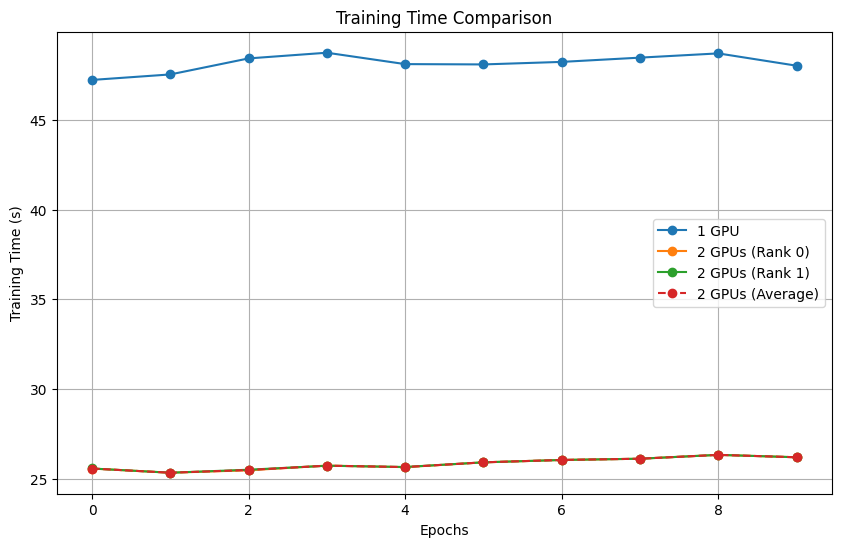

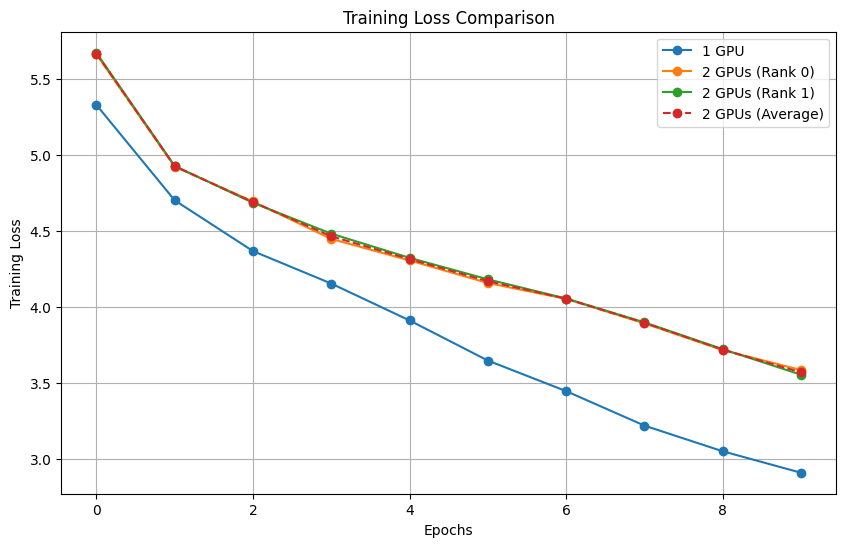

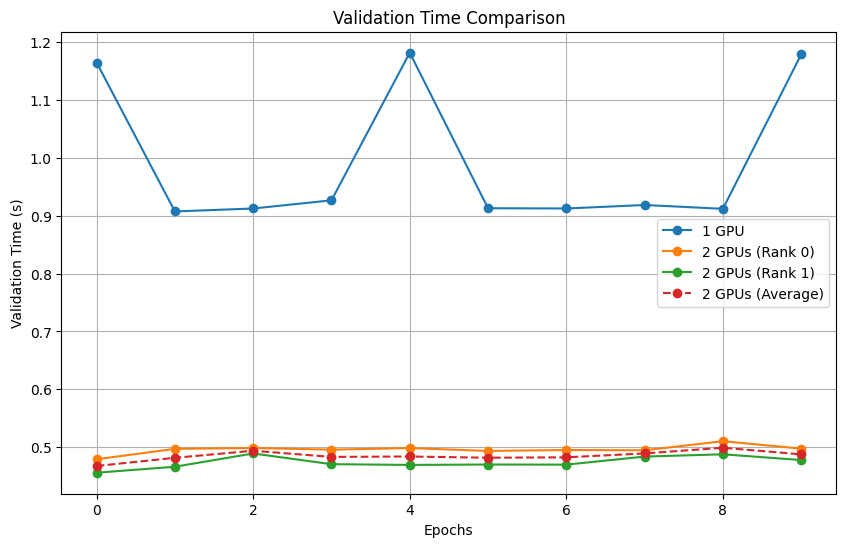

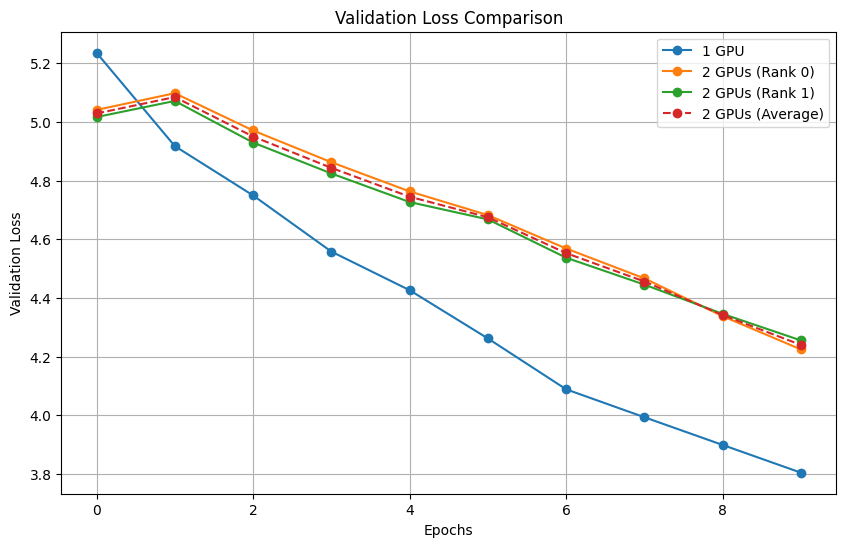

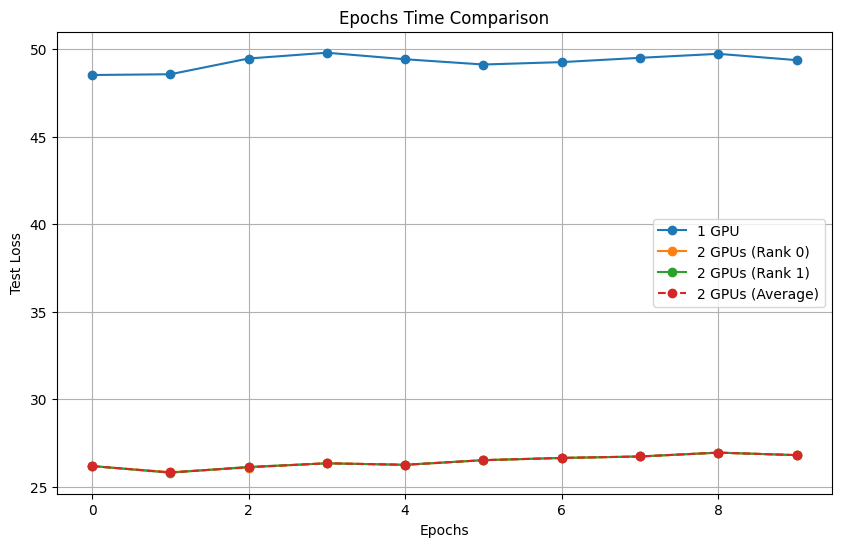

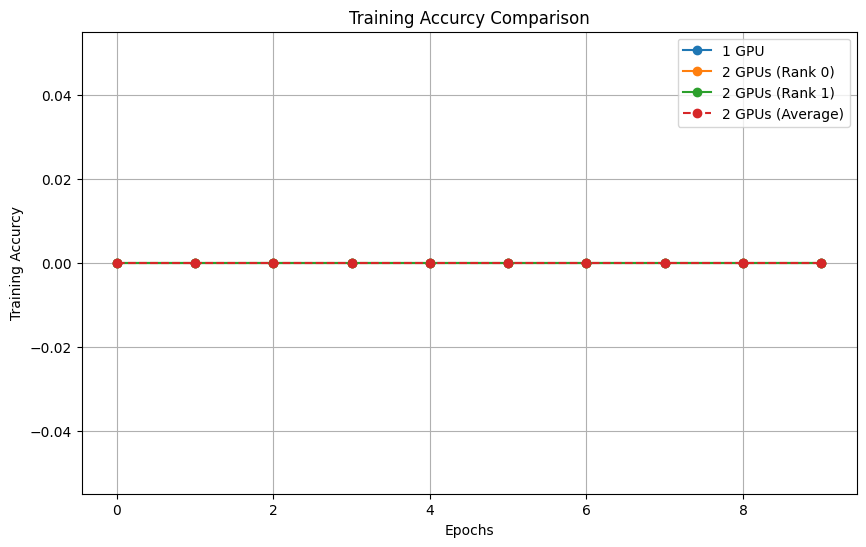

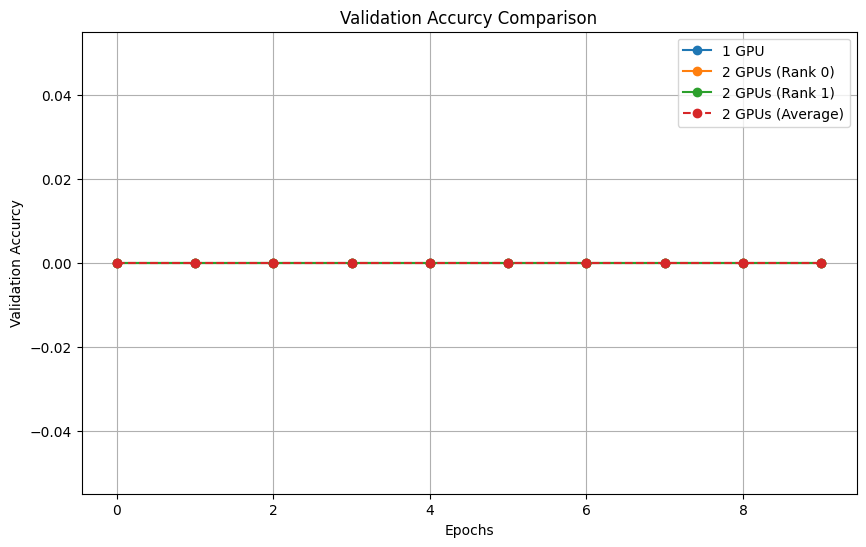

In [6]:
import json
import matplotlib.pyplot as plt
import numpy as np

def plot_training_metrics_seq2seq(json_file_1gpu, json_file_2gpus):
    """
    Generates plots comparing training metrics from 1-GPU and 2-GPU setups for a seq2seq model.
    Includes plots for rank 0, rank 1, and their average for the 2-GPU setup.
    """
    # Load 1-GPU data
    with open(json_file_1gpu, 'r') as f:
        data_1gpu = json.load(f)

    seq2seq_1gpu = data_1gpu[list(data_1gpu.keys())[0]]

    # Load 2-GPU data
    with open(json_file_2gpus, 'r') as f:
        data_2gpus = json.load(f)
    seq2seq_2gpus_rank0 = data_2gpus[list(data_2gpus.keys())[0]]
    seq2seq_2gpus_rank1 = data_2gpus[list(data_2gpus.keys())[1]]

    # Extract data for 1 GPU
    train_times_1gpu = seq2seq_1gpu['training_times']
    train_losses_1gpu = seq2seq_1gpu['train_losses']
    val_times_1gpu = seq2seq_1gpu['validation_times']
    val_losses_1gpu = seq2seq_1gpu['validation_losses']
    epoch_times_1gpu = seq2seq_1gpu['epoch_times']
    train_accurcy_1gpu = seq2seq_1gpu['train_accurcy']
    validation_accurcy_1gpu = seq2seq_1gpu['validation_accurcy']

    # Extract data for 2 GPUs (rank 0)
    train_times_2gpus_rank0 = seq2seq_2gpus_rank0['training_times']
    train_losses_2gpus_rank0 = seq2seq_2gpus_rank0['train_losses']
    val_times_2gpus_rank0 = seq2seq_2gpus_rank0['validation_times']
    val_losses_2gpus_rank0 = seq2seq_2gpus_rank0['validation_losses']
    epoch_times_2gpus_rank0 = seq2seq_2gpus_rank0['epoch_times']
    train_accurcy_2gpus_rank0 = seq2seq_2gpus_rank0['train_accurcy']
    validation_accurcy_2gpus_rank0 = seq2seq_2gpus_rank0['validation_accurcy']


    # Extract data for 2 GPUs (rank 1)
    train_times_2gpus_rank1 = seq2seq_2gpus_rank1['training_times']
    train_losses_2gpus_rank1 = seq2seq_2gpus_rank1['train_losses']
    val_times_2gpus_rank1 = seq2seq_2gpus_rank1['validation_times']
    val_losses_2gpus_rank1 = seq2seq_2gpus_rank1['validation_losses']
    epoch_times_2gpus_rank1 = seq2seq_2gpus_rank1['epoch_times']
    train_accurcy_2gpus_rank1 = seq2seq_2gpus_rank1['train_accurcy']
    validation_accurcy_2gpus_rank1 = seq2seq_2gpus_rank1['validation_accurcy']


    # Calculate averages for 2 GPUs
    train_times_2gpus_avg = np.mean([train_times_2gpus_rank0, train_times_2gpus_rank1], axis=0)
    train_losses_2gpus_avg = np.mean([train_losses_2gpus_rank0, train_losses_2gpus_rank1], axis=0)
    val_times_2gpus_avg = np.mean([val_times_2gpus_rank0, val_times_2gpus_rank1], axis=0)
    val_losses_2gpus_avg = np.mean([val_losses_2gpus_rank0, val_losses_2gpus_rank1], axis=0)
    epoch_times_2gpus_avg = np.mean([epoch_times_2gpus_rank0, epoch_times_2gpus_rank1], axis=0)
    train_accurcy_2gpus_avg = np.mean([train_accurcy_2gpus_rank0, train_accurcy_2gpus_rank1], axis=0)
    validation_accurcy_2gpus_avg = np.mean([validation_accurcy_2gpus_rank0, validation_accurcy_2gpus_rank1], axis=0)


    # Epochs for x-axis
    epochs = list(range(len(train_times_1gpu)))

    # Plot Training Times
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, train_times_1gpu, label='1 GPU', marker='o')
    plt.plot(epochs, train_times_2gpus_rank0, label='2 GPUs (Rank 0)', marker='o')
    plt.plot(epochs, train_times_2gpus_rank1, label='2 GPUs (Rank 1)', marker='o')
    plt.plot(epochs, train_times_2gpus_avg, label='2 GPUs (Average)', marker='o', linestyle='--')
    plt.xlabel('Epochs')
    plt.ylabel('Training Time (s)')
    plt.title('Training Time Comparison')
    plt.legend()
    plt.grid()
    plt.show()

    # Plot Training Losses
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, train_losses_1gpu, label='1 GPU', marker='o')
    plt.plot(epochs, train_losses_2gpus_rank0, label='2 GPUs (Rank 0)', marker='o')
    plt.plot(epochs, train_losses_2gpus_rank1, label='2 GPUs (Rank 1)', marker='o')
    plt.plot(epochs, train_losses_2gpus_avg, label='2 GPUs (Average)', marker='o', linestyle='--')
    plt.xlabel('Epochs')
    plt.ylabel('Training Loss')
    plt.title('Training Loss Comparison')
    plt.legend()
    plt.grid()
    plt.show()

    # Plot Validation Times
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, val_times_1gpu, label='1 GPU', marker='o')
    plt.plot(epochs, val_times_2gpus_rank0, label='2 GPUs (Rank 0)', marker='o')
    plt.plot(epochs, val_times_2gpus_rank1, label='2 GPUs (Rank 1)', marker='o')
    plt.plot(epochs, val_times_2gpus_avg, label='2 GPUs (Average)', marker='o', linestyle='--')
    plt.xlabel('Epochs')
    plt.ylabel('Validation Time (s)')
    plt.title('Validation Time Comparison')
    plt.legend()
    plt.grid()
    plt.show()

    # Plot Validation Losses
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, val_losses_1gpu, label='1 GPU', marker='o')
    plt.plot(epochs, val_losses_2gpus_rank0, label='2 GPUs (Rank 0)', marker='o')
    plt.plot(epochs, val_losses_2gpus_rank1, label='2 GPUs (Rank 1)', marker='o')
    plt.plot(epochs, val_losses_2gpus_avg, label='2 GPUs (Average)', marker='o', linestyle='--')
    plt.xlabel('Epochs')
    plt.ylabel('Validation Loss')
    plt.title('Validation Loss Comparison')
    plt.legend()
    plt.grid()
    plt.show()

    # Plot Test Losses
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, epoch_times_1gpu, label='1 GPU', marker='o')
    plt.plot(epochs, epoch_times_2gpus_rank0, label='2 GPUs (Rank 0)', marker='o')
    plt.plot(epochs, epoch_times_2gpus_rank1, label='2 GPUs (Rank 1)', marker='o')
    plt.plot(epochs, epoch_times_2gpus_avg, label='2 GPUs (Average)', marker='o', linestyle='--')
    plt.xlabel('Epochs')
    plt.ylabel('Test Loss')
    plt.title('Epochs Time Comparison')
    plt.legend()
    plt.grid()
    plt.show()

    # Plot Training Accurcy
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, train_accurcy_1gpu, label='1 GPU', marker='o')
    plt.plot(epochs, train_accurcy_2gpus_rank0, label='2 GPUs (Rank 0)', marker='o')
    plt.plot(epochs, train_accurcy_2gpus_rank1, label='2 GPUs (Rank 1)', marker='o')
    plt.plot(epochs, train_accurcy_2gpus_avg, label='2 GPUs (Average)', marker='o', linestyle='--')
    plt.xlabel('Epochs')
    plt.ylabel('Training Accurcy')
    plt.title('Training Accurcy Comparison')
    plt.legend()
    plt.grid()
    plt.show()

    # Plot Validation Accurcy
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, validation_accurcy_1gpu, label='1 GPU', marker='o')
    plt.plot(epochs, validation_accurcy_2gpus_rank0, label='2 GPUs (Rank 0)', marker='o')
    plt.plot(epochs, validation_accurcy_2gpus_rank1, label='2 GPUs (Rank 1)', marker='o')
    plt.plot(epochs, validation_accurcy_2gpus_avg, label='2 GPUs (Average)', marker='o', linestyle='--')
    plt.xlabel('Epochs')
    plt.ylabel('Validation Accurcy')
    plt.title('Validation Accurcy Comparison')
    plt.legend()
    plt.grid()
    plt.show()

    # Plot Test Accurcy
    ''' plt.figure(figsize=(10, 6))
    plt.plot(epochs, test_Accurcys_1gpu, label='1 GPU', marker='o')
    plt.plot(epochs, test_Accurcys_2gpus_rank0, label='2 GPUs (Rank 0)', marker='o')
    plt.plot(epochs, test_Accurcys_2gpus_rank1, label='2 GPUs (Rank 1)', marker='o')
    plt.plot(epochs, test_Accurcys_2gpus_avg, label='2 GPUs (Average)', marker='o', linestyle='--')
    plt.xlabel('Epochs')
    plt.ylabel('Test Accurcy')
    plt.title('Test Accurcy Comparison')
    plt.legend()
    plt.grid()
    plt.show()'''

if __name__ == "__main__":
    plot_training_metrics_seq2seq('/content/RNN_10epochs_1GPU.json', '/content/RNN_10epochs_2GPU.json')